In [1]:
import pathlib

import matplotlib.pyplot as plt
import xarray
import zarr

xarray.set_options(display_style="html");


In [2]:
# Load surge data
paths = pathlib.Path('/Users/baart_f/data/dgds/ts').glob('*surge*.nc')
surge_ds = xarray.open_mfdataset(paths, combine='by_coords', concat_dim='time', data_vars=['surge'])
#  Load waterlevels
paths = pathlib.Path('/Users/baart_f/data/dgds/ts').glob('*waterlevel*.nc')
waterlevel_ds = xarray.open_mfdataset(paths, combine='by_coords', concat_dim='time', data_vars=['waterlevel'])

In [3]:
# concatenate under the assumption of corresponding dimensions
ds = xarray.combine_by_coords([surge_ds, waterlevel_ds], join='inner' )

In [5]:
!rm -r  /Users/baart_f/data/dgds/ts/gtsr.zarr
chunked = ds.chunk({'time': 10000, 'stations': 10})
compressor = zarr.Blosc(cname='lz4', clevel=5, shuffle=2)
encoding = {'surge': {'compressor': compressor}, 'waterlevel': {'compressor': compressor}}
chunked.to_zarr('/Users/baart_f/data/dgds/ts/gtsr.zarr', consolidated=True, encoding=encoding)

In [43]:
# Or iterative
# paths = pathlib.Path('/Users/baart_f/data/dgds/ts').glob('*surge*.nc')
# compressor = zarr.Blosc(cname='zstd', clevel=3, shuffle=2)
# encoding = {'surge': {'compressor': compressor}, 'waterlevel': {'compressor': compressor}}

# for  path in paths:
#     ds_i = xarray.open_dataset(path)
#     chunked = ds_i.chunk({'time': 1000, 'stations': 10})
#     chunked.to_zarr('/Users/baart_f/data/dgds/ts/gtsr-append.zarr', mode='a', append_dim='time')



In [6]:
ds = xarray.open_zarr('/Users/baart_f/data/dgds/ts/gtsr.zarr')


In [7]:
x = ds['station_x_coordinate'].values
y = ds['station_y_coordinate'].values

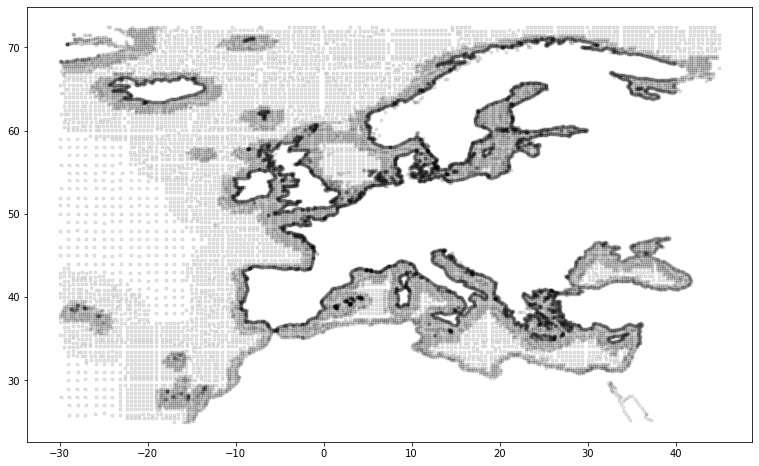

In [8]:
fig, ax = plt.subplots(figsize=(13, 8))
ax.plot(x, y, 'k.', alpha=0.1) 

In [20]:
df = ds.station_id.to_dataframe(0)
#  convert  to string
names = [x.decode() for x in ds.station_id.values]
df['name'] = names

In [21]:
import re
import shapely.geometry
import pyproj
patterns = ['id_coast_glob_eur_\d+', 'id_reg_grid_eur_\d+',  'id_obs_\w+',  '(ARC|BAL|BS|IBIS|MED|NWS)_(IR|GL|BO|BS|MO|NO)_(TS|PR)_MO_[\w\d]+', 'islands_[\w]+', 'currents_[\w]+']
patterns = [re.compile(pattern) for pattern in patterns]

known = [any(pattern.search(name) for pattern in patterns) for name in names]
df['known'] = known
df['geom']  = df.apply(
    lambda row: shapely.geometry.Point(row['station_x_coordinate'], row['station_y_coordinate']),
    axis=1
)

In [22]:
import geopandas
import pyproj
crs = pyproj.CRS.from_user_input(4326)
print(repr(crs))
gdf = geopandas.GeoDataFrame(df, geometry='geom', crs=crs)
points = gdf[['geom', 'name']]
with open('gtsm-copernicus.json', 'w') as f:
    f.write(points.to_json())

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich



In [15]:
!mapbox upload siggyf.gtsm-copernicus gtsm-copernicus.json

Uploading data source  [####################################]  100%          
{"id":"ck70dzfwh0zuq2opipqnxhzgo","name":"gtsm-copernicus","complete":false,"error":null,"created":"2020-02-24T11:37:26.866Z","modified":"2020-02-24T11:37:26.866Z","tileset":"siggyf.gtsm-copernicus","owner":"siggyf","progress":0}


In [18]:
# query by box like this
box = shapely.geometry.box(3, 7,  51, 53.5)
gdf['in_nl'] =  gdf.geom.apply(lambda geom: box.intersects(geom))
gdf.query('in_nl').head()

,station_x_coordinate,station_y_coordinate,station_name,0,name,known,geom,in_nl
stations,,,,,,,,
0,24.08936,34.82666,b'id_coast_glob_eur_00001',b'id_coast_glob_eur_00001',id_coast_glob_eur_00001,True,POINT (24.08936 34.82666),True
1,24.08936,34.87061,b'id_coast_glob_eur_00002',b'id_coast_glob_eur_00002',id_coast_glob_eur_00002,True,POINT (24.08936 34.87061),True
2,26.90186,35.36865,b'id_coast_glob_eur_00003',b'id_coast_glob_eur_00003',id_coast_glob_eur_00003,True,POINT (26.90186 35.36865),True
3,26.88721,35.39795,b'id_coast_glob_eur_00004',b'id_coast_glob_eur_00004',id_coast_glob_eur_00004,True,POINT (26.88721 35.39795),True
4,26.96045,35.42725,b'id_coast_glob_eur_00005',b'id_coast_glob_eur_00005',id_coast_glob_eur_00005,True,POINT (26.96045 35.42725),True


In [61]:
patterns = ['Vlissingen', 'HoekVanHolland', 'Ijmuiden', 'DenHelder', 'Harlingen', 'Delfzijl']
# Look up  stations and  drop the ones  that have  a postfix (TG/NAP)
patterns = [re.compile(pattern + '$') for  pattern  in  patterns]
selected =  gdf[gdf['name'].apply(lambda x: any(pattern.search(x) for pattern in patterns))]
labels =  selected.name
selected

,station_x_coordinate,station_y_coordinate,station_name,0,name,known,geom,in_nl
stations,,,,,,,,
22426,6.936035,53.327636,b'NWS_NO_TS_MO_Delfzijl',b'NWS_NO_TS_MO_Delfzijl',NWS_NO_TS_MO_Delfzijl,True,POINT (6.93604 53.32764),True
22427,4.738770,52.961426,b'NWS_NO_TS_MO_DenHelder',b'NWS_NO_TS_MO_DenHelder',NWS_NO_TS_MO_DenHelder,True,POINT (4.73877 52.96143),True
22443,5.295410,53.210449,b'NWS_NO_TS_MO_Harlingen',b'NWS_NO_TS_MO_Harlingen',NWS_NO_TS_MO_Harlingen,True,POINT (5.29541 53.21045),True
22453,4.123535,51.979980,b'NWS_NO_TS_MO_HoekVanHolland',b'NWS_NO_TS_MO_HoekVanHolland',NWS_NO_TS_MO_HoekVanHolland,True,POINT (4.12354 51.97998),True
22465,4.548340,52.463379,b'NWS_NO_TS_MO_Ijmuiden',b'NWS_NO_TS_MO_Ijmuiden',NWS_NO_TS_MO_Ijmuiden,True,POINT (4.54834 52.46338),True
22501,3.596191,51.452636,b'NWS_NO_TS_MO_Vlissingen',b'NWS_NO_TS_MO_Vlissingen',NWS_NO_TS_MO_Vlissingen,True,POINT (3.59619 51.45264),True


0.13167935287410776

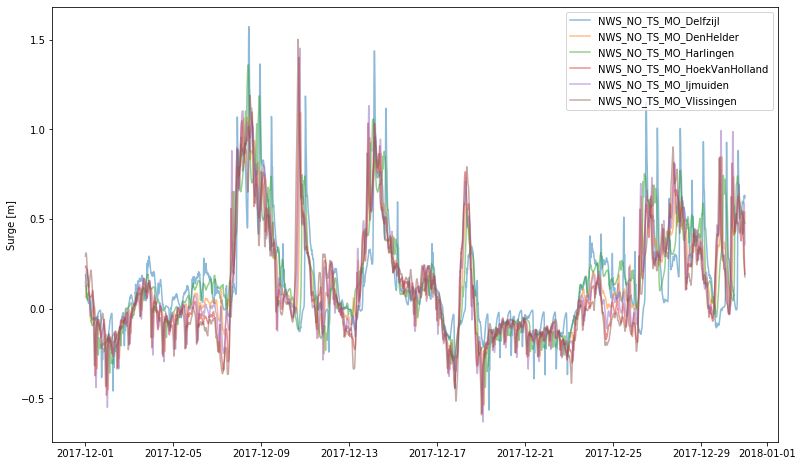

In [81]:
surge = ds.surge[:, selected.index].values
t = ds.time.values
fig, ax = plt.subplots(figsize=(13, 8))
for label, arr in zip(labels,  surge.T):
    ax.plot(t, arr, label=label, alpha=0.5)
ax.legend(loc='best')
ax.set_ylabel('Surge [m]')
surge.mean(axis=(0, 1))

0.25780807054237026

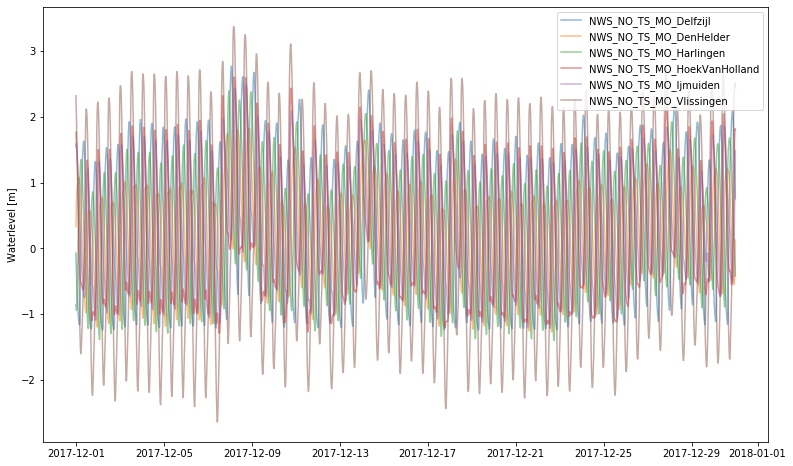

In [82]:
waterlevel = ds.waterlevel[:, selected.index].values
fig, ax = plt.subplots(figsize=(13, 8))
for label, arr in zip(labels,  waterlevel.T):
    ax.plot(t, arr, label=label, alpha=0.5)
ax.legend(loc='best')
ax.set_ylabel('Waterlevel [m]')
waterlevel.mean(axis=(0, 1))

0.12612871766826253

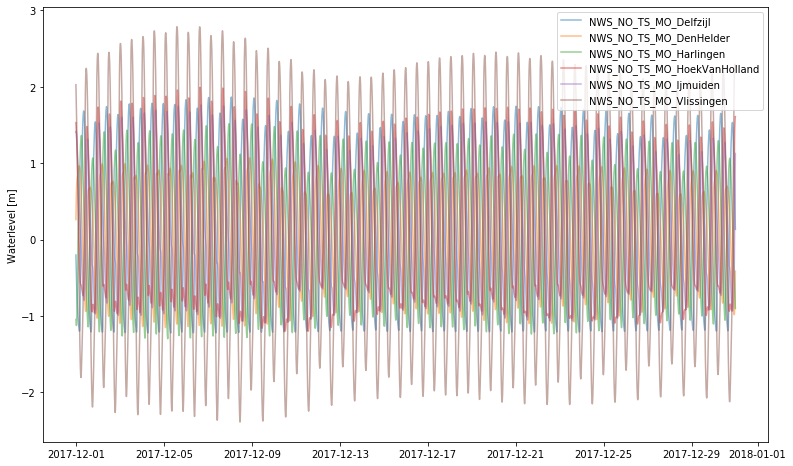

In [84]:
tide = waterlevel - surge
fig, ax = plt.subplots(figsize=(13, 8))
for label, arr in zip(labels,  tide.T):
    ax.plot(t, arr, label=label, alpha=0.5)
ax.legend(loc='best')
ax.set_ylabel('Waterlevel [m]')
tide.mean(axis=(0, 1))